# BPS Bus Route Optimization

### Problem Statement
The Boston Public Schools has released an RFP seeking to find a solution to optimize their strategy for student transportation to and from school. 

From BPS: "In [2016], transportation costs accounted for \$110 million or 11% of the district’s budget. On a per pupil basis, BPS’s transportation cost is the second highest and more than five times the average of the largest 200 public school districts."

In order to make their transporation network more efficient and potentially less costly, BPS has posed the following two challenges.

#### Step 1: Optimize Bus Stop Locations 

We are working to consolidate bus stops to increase efficiency and decrease student ride time, while also ensuring that students are able to walk safely and quickly to a nearby bus stop. Based on where students live, their destination schools, and the type of service required (i.e. Corner Stop, Door to Door, Wheelchair) how will you assign students to a stop?

#### Step 2: Improve Routing Efficiencies

We are working to get all students to school as quickly as possible in time for the start of the day. Given the location of bus stops, how would you connect these stops to schools over the course of a day creating a full route for a bus that starts and ends at a given bus yard? How will you account for different types of services required (Corner Stop, Door to Door, Wheelchair)?"



### Outcome
The expected outcome of this project is a modeled system of a minimized number of bus stops and routes that provide efficient transportation for every student to and from school. The system will be measured by comparison to the baseline of the existing BPS transportation system as described below:

Scenario | # of required busses |Service hours | Service miles
---| ---| ---
current BPS system | 630 | 3,600 | 44,500

### Approach

1. Data Visualization and Exploration: I will start by visualizing the dsitribution of students across Boston using the mapping libraries
2. Bus Stop Optimization: I hypothesize that by reducing the number of bus stops, the number of service hours will reduce, creating a more efficient system. In order to model this, I will look to highly dense areas and students' maximum walking distance to see if any walking radii overlap. If a student's max walking distance overlaps with that of another student, there is a potential for stops to be combined.
3. 
4. 

### The Data\*

BPS has made available a dataset capturing information for 90 schools and nearly 5000 students. The feautres included in the dataset are as follows:

Variable | Description | Type of Variable
---| ---| ---
Street Number | House number of student | continuous integer
Street Name |  Name of the street on which the student lives | categorical string
Zip Code | Zip Code in which the student lives | categorical integer 
Latitude | Geodetic coordinate system in decimal degrees | continuous float
Longitude | Geodetic coordinate system in decimal degrees | continuous float
Pickup Type | Corner or Door-to-Door | categorical string
Grade | Grade of the student | categorical integer
Geocode | BPS tracks various neighborhoods by census ‘geocodes’ which we use to analyze student neighborhoods | continuous integer
Neighborhood Safety Score | Based on amount of reported violent crime in neighborhood -- 7 = high level and 1 represents a low level | categorical integer
MaxWalk | Maximum distance student should walk to a stop. Actual walking distance along a common path. Each student will have specific max walking distance based on their grade and rates of reported crime within neighborhood | continuous float
Assigned School | School student is required to be transported to and from each day | categorical string
Current School Start | Arrive at school between 10-15 minutes before the start of school. While the bus needs to arrive 10-15 minutes before the start of school, the bus should plan to leave at the start of school. This allows time for buses to unload and builds in “recovery time” to account for unexpected delays on the route | time
Current School End | Time between school start time and school end time is the length of the school day for that school. Assume all students go home at the end of the day (i.e., they attend no after school activities). As detailed in Appendix 1: Rules of the Road buses should arrive by the school’s end time and leave no later than 15 minutes afterward | time
School Address | Full address of school | categorical string
School Lat | Geodetic coordinate system in decimal degrees | continuous float
School Long | Geodetic coordinate system in decimal degrees | continuous float


\* The data provided by BPS is not acutal student information. In order to protect students' safety and privay the data provided by the BPS is only representative of student information.

### Initial Setup and Package Import

In [456]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
import sklearn as sk

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

Load Data

In [457]:
df = pd.read_csv('https://raw.githubusercontent.com/tylershannon/BPS-BusRouteOptimization/master/Data/BPS-StudentInformation.csv')

# 1 - Data Visualization and Exploration

Display data

In [458]:
df.head()

,StreetNum,StreetName,ZipCode,Lat,Long,PickupType,Grade,Geocode,NeighborhoodSafetyScore,MaxWalk,AssignedSchool,CurrentSchoolStart,CurrentSchoolEnd,SchoolAddress,SchoolLat,SchoolLong
0,1,CLAREMONT PK,2118,42.342049,-71.080765,Corner,3,25025070800,3,0.5,Johnny Pesky School,8:30:00 AM,4:00:00 PM,"236 Beech St, 02131",42.281233,-71.141075
1,1,DUNFORD ST,2119,42.317420,-71.094550,Corner,1,25025081500,5,0.4,Tris Speaker School,7:30:00 AM,2:10:00 PM,"40 Pershing Rd, 02130",42.318999,-71.114084
2,1,ORGAN PARK ST,2131,42.288240,-71.113130,D2D,6,25025110301,4,0.5,John Gorman School,8:30:00 AM,4:00:00 PM,"110 Beachview Rd, 02128",42.391629,-71.005053
3,2295,CENTRE ST,2132,42.271750,-71.161770,Corner,1,25025130402,2,0.4,Roger Clemens School,7:30:00 AM,3:00:00 PM,"200 Heath St, 02130",42.326009,-71.106552
4,1,WESTINGHOUSE PZ,2136,42.359400,-71.058700,D2D,4,25025030300,7,0.3,Joe Dobson School,8:30:00 AM,4:00:00 PM,"61 School St, 02119",42.313946,-71.097867


In [459]:
df.shape

(4998, 16)

Create dataframe of schools and their locations (constrained to unique instances)

In [460]:
SchoolLoc = pd.DataFrame(df.AssignedSchool.unique())
SchoolLoc['SchoolLat'] = df.SchoolLat
SchoolLoc['SchoolLong'] = df.SchoolLong

Count the number of instances for the different types of bus stops

In [461]:
df['PickupType'].value_counts()

Corner        2922
D2D           2036
Wheelchair      40
Name: PickupType, dtype: int64

Make new feature for flexability of stop location based on type of bus stop

In [462]:
df['StopFlex'] = 0.0

for i in range(len(df.PickupType)):
    if df.PickupType[i] == 'Corner':
        df.StopFlex[i] = df.MaxWalk[i]

df.head()

,StreetNum,StreetName,ZipCode,Lat,Long,PickupType,Grade,Geocode,NeighborhoodSafetyScore,MaxWalk,AssignedSchool,CurrentSchoolStart,CurrentSchoolEnd,SchoolAddress,SchoolLat,SchoolLong,StopFlex
0,1,CLAREMONT PK,2118,42.342049,-71.080765,Corner,3,25025070800,3,0.5,Johnny Pesky School,8:30:00 AM,4:00:00 PM,"236 Beech St, 02131",42.281233,-71.141075,0.5
1,1,DUNFORD ST,2119,42.317420,-71.094550,Corner,1,25025081500,5,0.4,Tris Speaker School,7:30:00 AM,2:10:00 PM,"40 Pershing Rd, 02130",42.318999,-71.114084,0.4
2,1,ORGAN PARK ST,2131,42.288240,-71.113130,D2D,6,25025110301,4,0.5,John Gorman School,8:30:00 AM,4:00:00 PM,"110 Beachview Rd, 02128",42.391629,-71.005053,0.0
3,2295,CENTRE ST,2132,42.271750,-71.161770,Corner,1,25025130402,2,0.4,Roger Clemens School,7:30:00 AM,3:00:00 PM,"200 Heath St, 02130",42.326009,-71.106552,0.4
4,1,WESTINGHOUSE PZ,2136,42.359400,-71.058700,D2D,4,25025030300,7,0.3,Joe Dobson School,8:30:00 AM,4:00:00 PM,"61 School St, 02119",42.313946,-71.097867,0.0


### Create Map and Scatter Plot

Resize figures

In [463]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

Crete Basemap instance

In [464]:
m = Basemap(resolution='f', #c, l, i, h, f, or None
           projection='merc',
           lat_0=42.321827, lon_0=-71.081543,
           llcrnrlon=-71.198616, llcrnrlat=42.227755, urcrnrlon=-70.941811, urcrnrlat=42.403939)

Define Map features

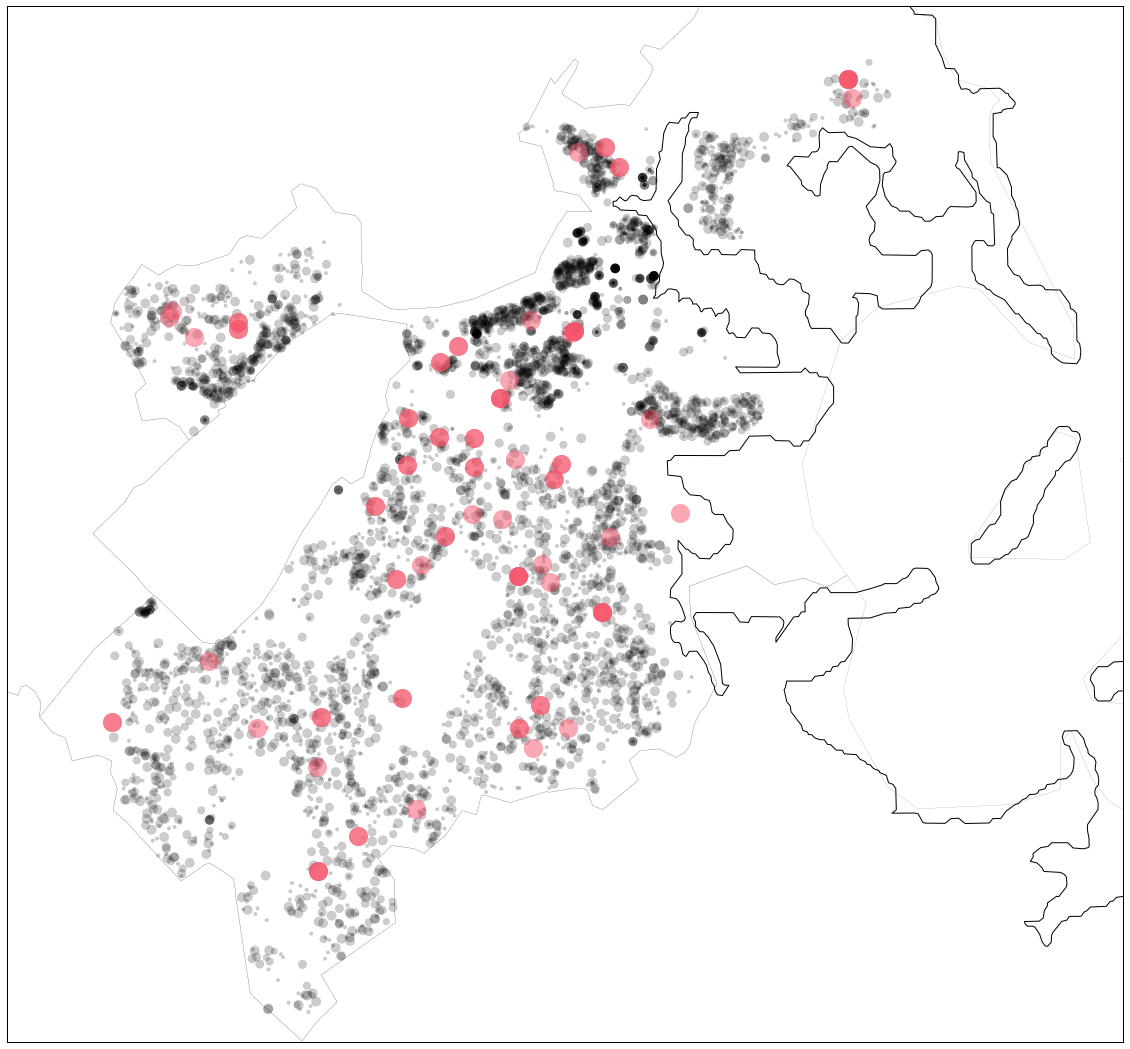

In [465]:
m.drawmapboundary(fill_color='#ffffff')
m.fillcontinents(color='#ffffff', lake_color='#ffffff', alpha=0)
m.drawcoastlines()
m.drawcounties()

stoplons = df.Long
stoplats = df.Lat

schoollons = SchoolLoc.SchoolLong
schoollats = SchoolLoc.SchoolLat

stopx, stopy = m(list(stoplons), list(stoplats))
schoolx, schooly = m(list(schoollons), list(schoollats))

size = df.StopFlex * 600 + 50

m.scatter(stopx, stopy, marker='.', s = size, color = 'k', alpha = .2)
m.scatter(schoolx, schooly, marker = 'o', s = 350, c = '#F6546A', alpha=0.5)
#m.readshapefile('/Users/tylershannon/Desktop/bos_land/bos_land', 'bosshape')

#plt.savefig('BPS_AllSchools', bbox_inches='tight')

### Individual School Distribution Map

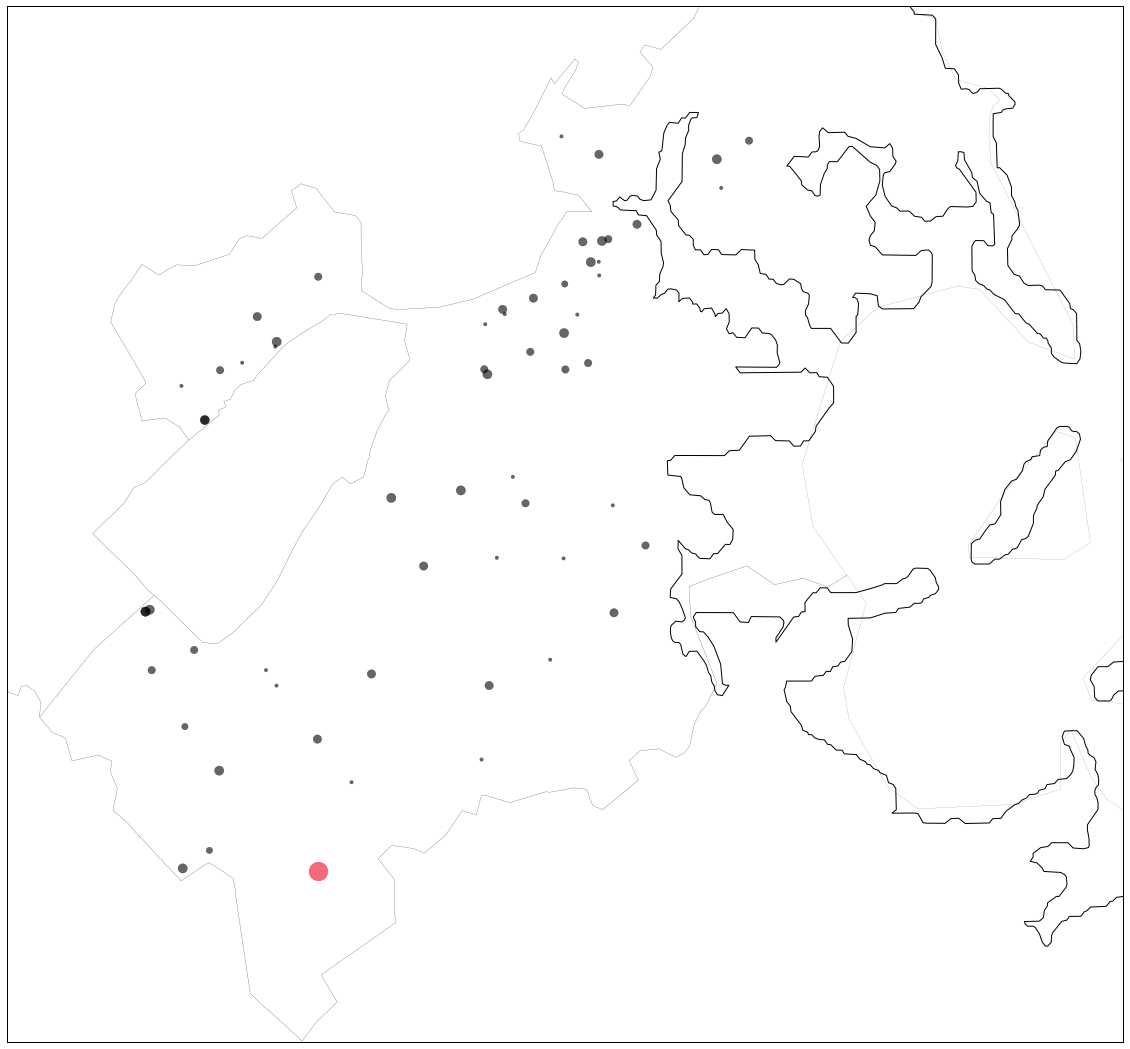

In [466]:
m.drawmapboundary(fill_color='#ffffff')
m.fillcontinents(color='#ffffff', lake_color='#ffffff', alpha=0)
m.drawcoastlines()
m.drawcounties()

SchoolToShow = 'Reggie Smith School'

stoplons = df.loc[df['AssignedSchool'] == SchoolToShow].Long
stoplats = df.loc[df['AssignedSchool'] == SchoolToShow].Lat

schoollons = SchoolLoc.loc[df['AssignedSchool'] == SchoolToShow].SchoolLong
schoollats = SchoolLoc.loc[df['AssignedSchool'] == SchoolToShow].SchoolLat

stopx, stopy = m(list(stoplons), list(stoplats))
schoolx, schooly = m(list(schoollons), list(schoollats))

size = df.StopFlex * 600 + 50

m.scatter(stopx, stopy, marker='.', s = size, color = 'k', alpha = .6)
m.scatter(schoolx, schooly, marker = 'o', s = 350, c = '#F6546A', alpha=0.5)
#m.readshapefile('/Users/tylershannon/Desktop/bos_land/bos_land', 'bosshape')

#plt.savefig('BPS_'+SchoolToShow, bbox_inches='tight')

### Pickup Type Count Plot

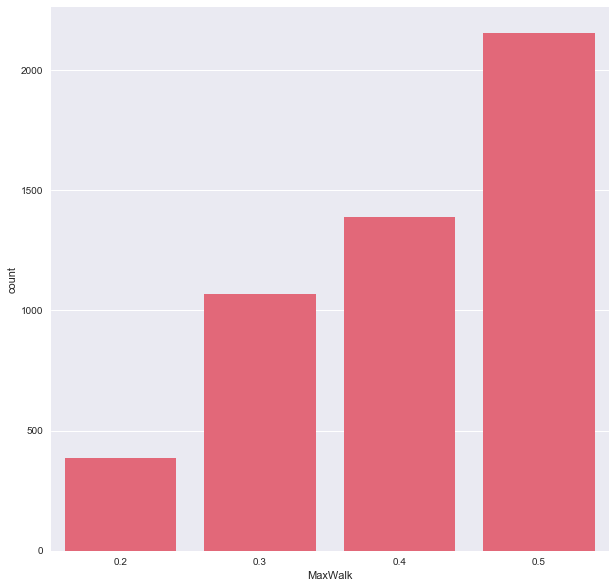

In [467]:
fig = plt.subplots(figsize=[10, 10])
count_plot = sns.countplot(x= df.MaxWalk, data=df, color = '#F6546A')

# 2 - Bus Stop Optimization w DBSCAN Clustering

First I will use DBSCAN to cluster bus stops that are within a set distance (Max Walk Distance) from one another.

### Initial Setup and Package Import

In [468]:
from sklearn.cluster import KMeans, DBSCAN
from collections import Counter
import time
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

### Setup coordinates and distance conversions
* Create matrix of stop location coordinates
* Create variable for conversion of miles to radians. The DBSCAN implementation with haversine uses radians for units.
* Radius of Earth is ~ 3,963.2 miles
* Convert the desired sample radius from miles to radians


In [670]:
stop_coords = df.as_matrix(columns=['Lat', 'Long'])
mi_per_radian = 3963.2
epsilon = 0.25 / mi_per_radian

In [671]:
stop_coords

array([[ 42.342049, -71.080765],
       [ 42.31742 , -71.09455 ],
       [ 42.28824 , -71.11313 ],
       ..., 
       [ 42.27875 , -71.06603 ],
       [ 42.27715 , -71.06693 ],
       [ 42.276095, -71.067297]])

### Fit the DBSCAN model
* Here I fit the DBSCAN model using the stop_coords matrix. 
* The eps is the max distance that points can be from one another to be condisdered a cluster
* The min_samples is set at 1 so that a point that cannot be optimized remains in the dataset instead of being considered noise
* The number of DBSCAN attribute labels is assigned to num_clusters 

In [672]:
start_time = time.time()
#fit the DBSCAN model using the epsilon defined above for each existing bus stop location
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(stop_coords))
cluster_labels = db.labels_

#number of clusters
num_clusters = len(set(cluster_labels))

#print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(stop_coords, cluster_labels)))

Clustered 4,998 points down to 14 clusters, for 99.7% compression in 0.43 seconds
Silhouette coefficient: -0.299


### Create series with coordinates belonging to each cluster

In [673]:
clusters = pd.Series([stop_coords[cluster_labels==n] for n in range(num_clusters)])

In [674]:
clusters.head()

0    [[42.342049, -71.080765], [42.31742, -71.09455...
1    [[42.333614, -71.153143], [42.333614, -71.1531...
2    [[42.34848, -71.038813], [42.34848, -71.038813...
3    [[42.365976, -71.030423], [42.380951, -71.0313...
4                             [[42.344195, -71.03343]]
dtype: object

### Find the centroid point of each cluster to represent new stop location

In [675]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters[0:len(clusters)-1].map(get_centermost_point)

### Unzip each cluster centroid into new dataframe containing lat and lon

In [676]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()

,lat,lon
8,42.235610,-71.130660
9,42.252450,-71.143240
10,42.301015,-71.166797
11,42.337960,-71.096620
12,42.383082,-71.051581


### Plot new bus stop locations against the full set

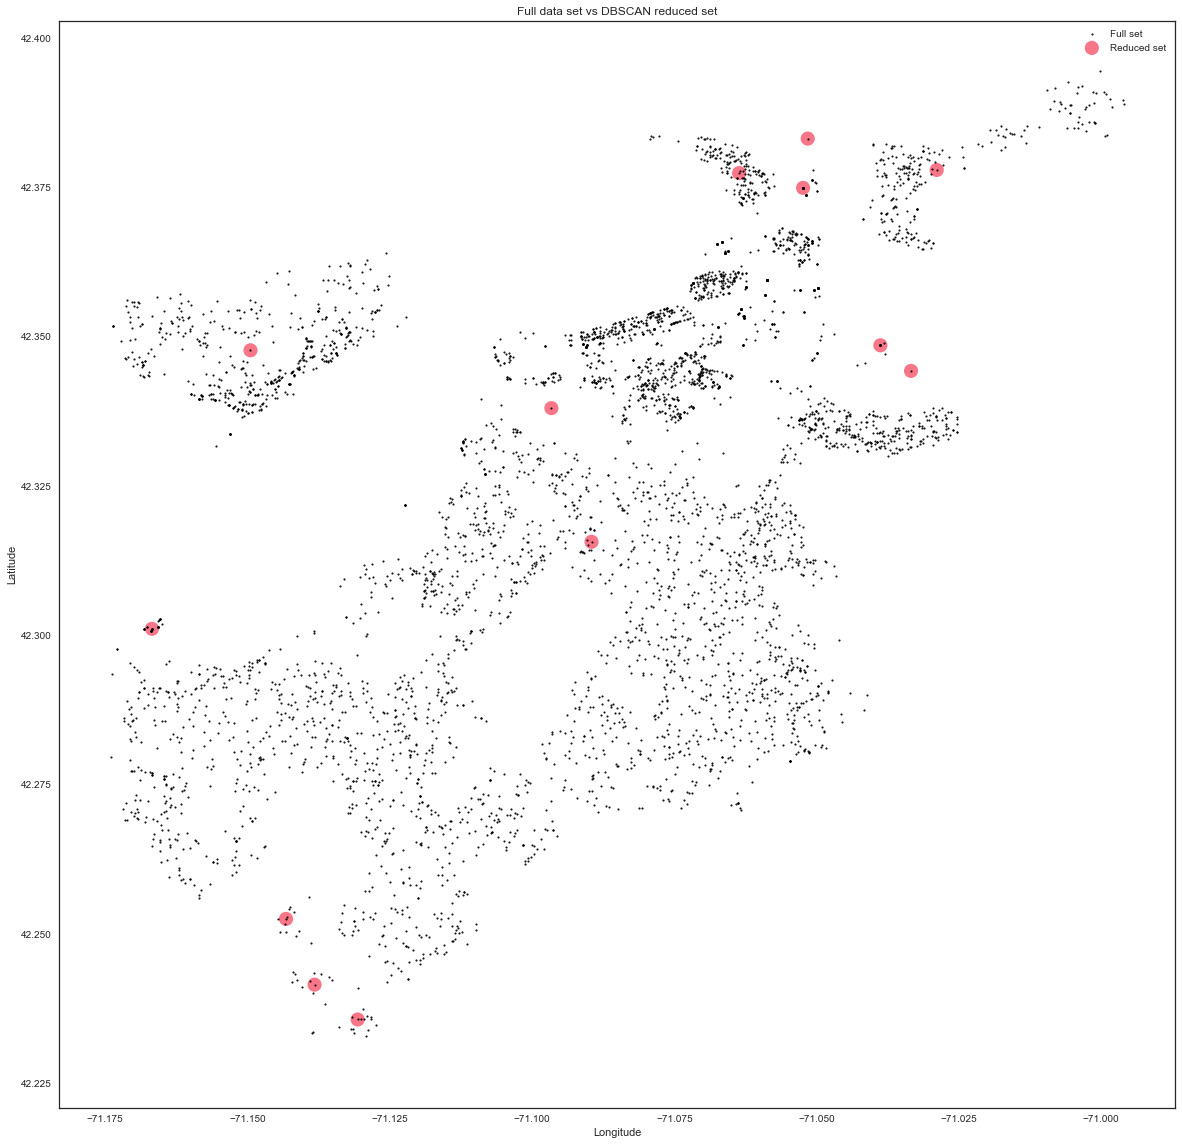

In [677]:
fig, ax = plt.subplots(figsize=[20, 20])
rs_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='#F6546A', edgecolor='None', alpha=0.8, s=200)
df_scatter = ax.scatter(df['Long'], df['Lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
ax.set_axis_bgcolor('white')
plt.show()
#plt.savefig('DBSCAN_eps_0_5', bbox_inches='tight')

# 3 - Bus Stop Optimization w Custom Clustering

### Import vincenty which is a method for measuring on an oblate spheroid (earth)

In [616]:
from geopy.distance import vincenty

In [640]:
df_copy = df.sample(n=len(df)) # n=len(df)

### Run clustering algorithm that finds local students within their max walking distance and assigns to a stop

In [642]:
test_dist = 0 # do not change
df_copy['StopGroup'] = 0 # do not change
group_inc = 1 # do not change
#df_copy['NewStopLat'] = 0.0 # do not change
#df_copy['NewStopLong'] = 0.0 # do not change

threshold = df_copy.MaxWalk

r = len(df_copy)

for i in range(r):
    if df_copy.StopGroup.iloc[i] == 0:
        base_coord = df_copy.Lat.iloc[i] , df_copy.Long.iloc[i]
        for x in range(r):    
            if i != x:
                test_coord = df_copy.Lat.iloc[x] , df_copy.Long.iloc[x]
                test_dist = vincenty(base_coord, test_coord).miles
                if test_dist <= threshold.iloc[x] and df_copy.StopGroup.iloc[x] == 0:
                    df_copy.StopGroup.iloc[i] = group_inc
                    df_copy.StopGroup.iloc[x] = group_inc
                    #df_copy.NewStopLat.iloc[x] = df_copy.Lat.iloc[i]
                    #df_copy.NewStopLong.iloc[x] = df_copy.Long.iloc[i]
                    #print(i, x, test_dist, group_inc)
        group_inc = group_inc + 1

### Create a matrix of students' starting coordinates

In [643]:
stop_coords = df_copy.as_matrix(columns=['Lat', 'Long'])
stop_coords[0:6]

array([[ 42.2992  , -71.06846 ],
       [ 42.35164 , -71.08405 ],
       [ 42.34916 , -71.13959 ],
       [ 42.26492 , -71.11967 ],
       [ 42.362687, -71.053315],
       [ 42.35469 , -71.07625 ]])

### Create series with coordinates belonging to each cluster

In [644]:
clusters = pd.Series([stop_coords[df_copy.StopGroup==n] for n in range(1, int(max(df_stop_opt_full.StopGroup)+1))])

In [645]:
#run the delete then comment out
for n in range(len(clusters)):
    if len(clusters[n]) == 0:
        del clusters[n]
clusters

0      [[42.2992, -71.06846], [42.29413, -71.06168], ...
1      [[42.35164, -71.08405], [42.35469, -71.07625],...
2      [[42.34916, -71.13959], [42.347114, -71.140312...
3      [[42.26492, -71.11967], [42.27051, -71.12123],...
4      [[42.362687, -71.053315], [42.3567, -71.04962]...
5      [[42.266969, -71.103873], [42.26549, -71.10491...
6      [[42.33354, -71.03755], [42.33274, -71.03345],...
7      [[42.37149, -71.03659], [42.36767, -71.03737],...
8      [[42.3437, -71.07094], [42.34314, -71.07711], ...
9      [[42.29903, -71.11209], [42.299744, -71.113309...
10     [[42.31251, -71.08912], [42.31472, -71.08209],...
11     [[42.342595, -71.095394], [42.343591, -71.0967...
12     [[42.290036, -71.054528], [42.28913, -71.06116...
13     [[42.28739, -71.04173], [42.28987, -71.04113],...
14     [[42.348766, -71.088189], [42.34993, -71.09049...
15     [[42.31074, -71.11787], [42.31012, -71.11738],...
16     [[42.28827, -71.1424], [42.28609, -71.13656], ...
17     [[42.31196, -71.09969], 

### Find the centroid point of each cluster to represent new stop location

In [646]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters[0:len(clusters)-1].map(get_centermost_point)

### Unzip each cluster centroid into new dataframe containing lat and lon

In [647]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rep_points.tail()
rep_points.shape

(102, 2)

### Plot new bus stop locations against the full set

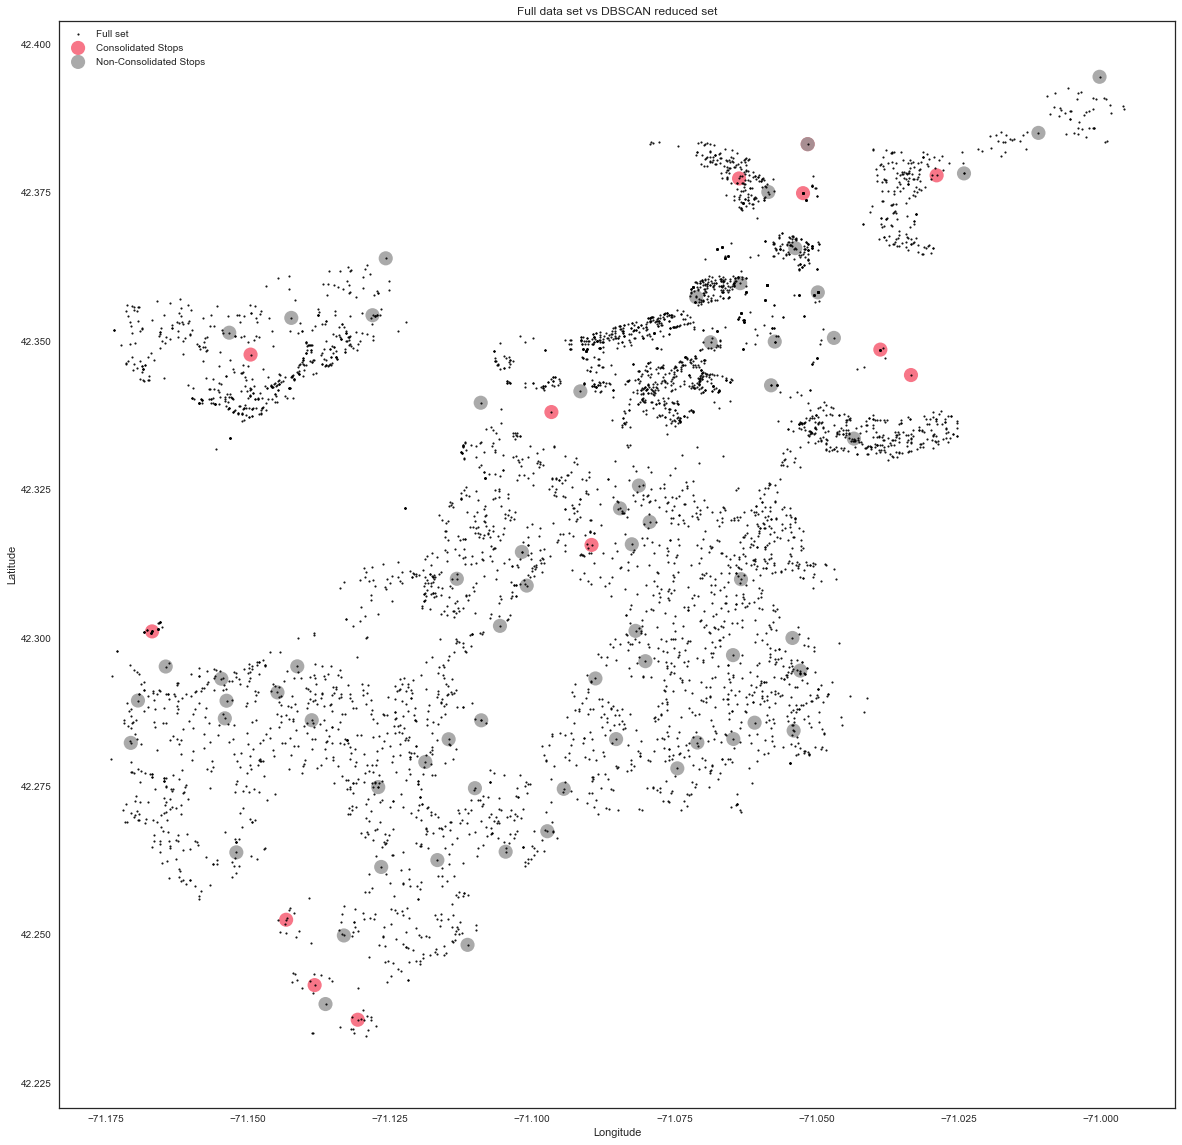

In [679]:
fig, ax = plt.subplots(figsize=[20, 20])
#plot optimized stops
opt_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='#F6546A', edgecolor='None', alpha=0.8, s=200)
#plot stops that weren't able to be optimized
nonopt_scatter = ax.scatter(df_copy.loc[df_copy['StopGroup'] == 0].Long, df_copy.loc[df_copy['StopGroup'] == 0].Lat, c='#959595', edgecolor='None', alpha=0.8, s=200)
#plot full set
df_scatter = ax.scatter(df_copy['Long'], df_copy['Lat'], c='k', alpha=0.9, s=3)
#plot options
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, opt_scatter, nonopt_scatter], ['Full set', 'Consolidated Stops', 'Non-Consolidated Stops'], loc='upper left')
ax.set_axis_bgcolor('white')
plt.show()

### Visualize the ratio of all students to the new stop locations

In [649]:
countsy = [len(df_copy), len(centermost_points), len(df_copy.loc[df_copy['StopGroup'] == 0])]
df_array = [countsy]
stacked_bar_data = pd.DataFrame(data = df_array, columns = countsx)
stacked_bar_data["Total"] = stacked_bar_data.StartingSet
stacked_bar_data['BusStops'] = 'Total'
stacked_bar_data['NonOptimizedStopsSudo'] = len(centermost_points) + len(df_copy.loc[df_copy['StopGroup'] == 0])

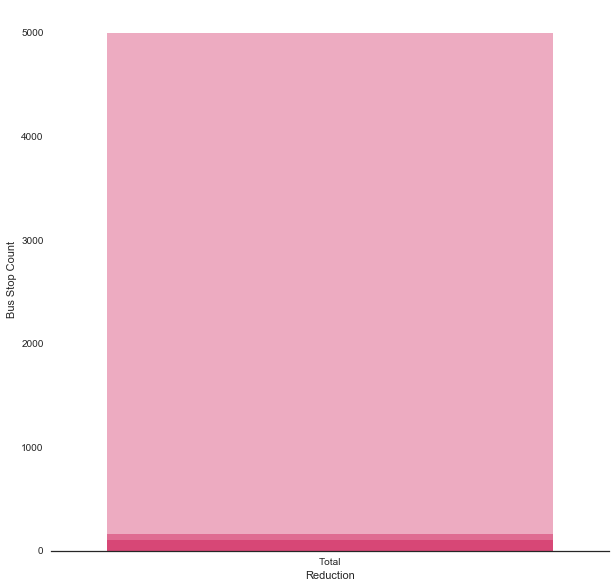

In [650]:
#Set general plot properties
sns.set_style("white")
fig, ax = plt.subplots(figsize=[10, 10])
c = '#ed145b'

#Plot 1 - background - "total" (top) series
sns.barplot(x = stacked_bar_data.BusStops, y = stacked_bar_data.Total, color = c, alpha = .4)

#Plot 2 - overlay - "bottom" series
middle_plot = sns.barplot(x = stacked_bar_data.BusStops, y = stacked_bar_data.NonOptimizedStopsSudo, color = c, alpha = .5)

#Plot 3 - overlay - "bottom" series
bottom_plot = sns.barplot(x = stacked_bar_data.BusStops, y = stacked_bar_data.OptimizedStops, color = c, alpha = .6)

#Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Bus Stop Count")
bottom_plot.set_xlabel("Reduction")

### TO DO:
* Clean up some of the formatting 
* Is there a more efficient way to build?
* Informed search techniques?
* Would an isochrone be applicable here to account for walking distances specific to Boston?
* Explore route optimization techniques